In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA


In [4]:

# Read the CSV, Date column is parsed as datetime
df = pd.read_csv("../data/cleaned_data.csv", parse_dates=["Date"])

# first few rows
df.head()


C:\Users\spide\AppData\Local\Temp\ipykernel_25832\3437458275.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv("../data/cleaned_data.csv", parse_dates=["Date"])


,Unnamed: 0,Transaction_ID,Date,Customer ID,Gender,Age,Product Category,Quantity,Price per Unit,Total Amount
0,0,1,2023-11-24,CUST001,Male,34.0,Beauty,3.0,50.0,150.0
1,1,2,2023-02-27,CUST002,Female,26.0,Clothing,2.0,500.0,1000.0
2,2,3,2023-01-13,CUST003,Male,50.0,Electronics,1.0,30.0,30.0
3,4,5,2023-05-21,CUST005,Male,37.0,Clothing,1.0,500.0,500.0
4,5,6,2023-06-05,CUST006,Male,30.0,Beauty,2.0,50.0,100.0


In [5]:
#Basic info check

# Number of rows & columns
print("Shape of DataFrame:", df.shape)

# Data types & non-null counts
print("\nData types and non-null counts:")
print(df.info())

# Check for any remaining NaNs
print("\nMissing values per column:")
print(df.isnull().sum())


Shape of DataFrame: (1000, 10)

Data types and non-null counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Unnamed: 0        1000 non-null   int64         
 1   Transaction_ID    1000 non-null   int64         
 2   Date              1000 non-null   datetime64[ns]
 3   Customer ID       1000 non-null   object        
 4   Gender            1000 non-null   object        
 5   Age               1000 non-null   float64       
 6   Product Category  1000 non-null   object        
 7   Quantity          1000 non-null   float64       
 8   Price per Unit    1000 non-null   float64       
 9   Total Amount      1000 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int64(2), object(3)
memory usage: 78.3+ KB
None

Missing values per column:
Unnamed: 0          0
Transaction_ID      0
Date                0
C

In [6]:
#Columns that we have
df.columns


Index(['Unnamed: 0', 'Transaction_ID', 'Date', 'Customer ID', 'Gender', 'Age',
       'Product Category', 'Quantity', 'Price per Unit', 'Total Amount'],
      dtype='object')

In [7]:
# Drop columns not used for clustering
df = df.drop(columns=["Unnamed: 0", "Transaction_ID"])
df.head()


,Date,Customer ID,Gender,Age,Product Category,Quantity,Price per Unit,Total Amount
0,2023-11-24,CUST001,Male,34.0,Beauty,3.0,50.0,150.0
1,2023-02-27,CUST002,Female,26.0,Clothing,2.0,500.0,1000.0
2,2023-01-13,CUST003,Male,50.0,Electronics,1.0,30.0,30.0
3,2023-05-21,CUST005,Male,37.0,Clothing,1.0,500.0,500.0
4,2023-06-05,CUST006,Male,30.0,Beauty,2.0,50.0,100.0


In [8]:
# Compute the reference date
ref_date = df["Date"].max()
print("Reference date (latest transaction) in dataset:", ref_date)


Reference date (latest transaction) in dataset: 2024-01-01 00:00:00


In [9]:
# Build customer level features and print columns

customer_df = (
    df.groupby("Customer ID")
    .agg(
        recency            = ("Date",        lambda x: (ref_date - x.max()).days),
        frequency          = ("Date",        "count"),
        monetary           = ("Total Amount","sum"),
        avg_basket         = ("Quantity",    "mean"),
        distinct_categories= ("Product Category", "nunique"),
        avg_price          = ("Price per Unit",  "mean"),
        age                = ("Age",         "mean"),
        gender             = ("Gender",      lambda x: x.mode()[0])
    )
    .reset_index()
)

# inspect which columns exist
print("Columns in customer_df after aggregation:", list(customer_df.columns))
customer_df.head()



Columns in customer_df after aggregation: ['Customer ID', 'recency', 'frequency', 'monetary', 'avg_basket', 'distinct_categories', 'avg_price', 'age', 'gender']


,Customer ID,recency,frequency,monetary,avg_basket,distinct_categories,avg_price,age,gender
0,CUST001,38,1,150.0,3.0,1,50.0,34.0,Male
1,CUST002,308,1,1000.0,2.0,1,500.0,26.0,Female
2,CUST003,353,1,30.0,1.0,1,30.0,50.0,Male
3,CUST005,225,1,500.0,1.0,1,500.0,37.0,Male
4,CUST006,210,1,100.0,2.0,1,50.0,30.0,Male


In [10]:
# Inspect customer_df
print("Shape of customer_df:", customer_df.shape)
print("\nData types:")
print(customer_df.dtypes)

print("\nFirst 10 rows:")
print(customer_df.head(10))

print("\nSummary statistics (numeric columns):")
print(customer_df.describe())


Shape of customer_df: (1000, 9)

Data types:
Customer ID             object
recency                  int64
frequency                int64
monetary               float64
avg_basket             float64
distinct_categories      int64
avg_price              float64
age                    float64
gender                  object
dtype: object

First 10 rows:
  Customer ID  recency  frequency  monetary  avg_basket  distinct_categories  \
0     CUST001       38          1     150.0         3.0                    1   
1     CUST002      308          1    1000.0         2.0                    1   
2     CUST003      353          1      30.0         1.0                    1   
3     CUST005      225          1     500.0         1.0                    1   
4     CUST006      210          1     100.0         2.0                    1   
5     CUST007      251          1      30.0         1.0                    1   
6     CUST008      294          1      50.0         2.0                    1   
7     

In [11]:
# Map Gender to numeric
customer_df["gender_num"] = customer_df["gender"].map({"Male": 0, "Female": 1})

# Inspect to confirm
customer_df.head()


,Customer ID,recency,frequency,monetary,avg_basket,distinct_categories,avg_price,age,gender,gender_num
0,CUST001,38,1,150.0,3.0,1,50.0,34.0,Male,0
1,CUST002,308,1,1000.0,2.0,1,500.0,26.0,Female,1
2,CUST003,353,1,30.0,1.0,1,30.0,50.0,Male,0
3,CUST005,225,1,500.0,1.0,1,500.0,37.0,Male,0
4,CUST006,210,1,100.0,2.0,1,50.0,30.0,Male,0


In [12]:
# Map the aggregated "gender" column to numeric

customer_df["gender_num"] = customer_df["gender"].map({"Male": 0, "Female": 1})

# Drop the old “gender” column - we do not need it
customer_df = customer_df.drop(columns=["gender"])

# Verify
print(customer_df.head())


  Customer ID  recency  frequency  monetary  avg_basket  distinct_categories  \
0     CUST001       38          1     150.0         3.0                    1   
1     CUST002      308          1    1000.0         2.0                    1   
2     CUST003      353          1      30.0         1.0                    1   
3     CUST005      225          1     500.0         1.0                    1   
4     CUST006      210          1     100.0         2.0                    1   

   avg_price   age  gender_num  
0       50.0  34.0           0  
1      500.0  26.0           1  
2       30.0  50.0           0  
3      500.0  37.0           0  
4       50.0  30.0           0  


In [13]:
# Drop Customer ID, we are keeping only numeric feature columns
features = customer_df.drop(columns=["Customer ID"])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

scaled_df = pd.DataFrame(X_scaled, columns=features.columns)
scaled_df.head()

,recency,frequency,monetary,avg_basket,distinct_categories,avg_price,age,gender_num
0,-1.436487,0.0,-0.546704,0.429265,0.0,-0.685123,-0.540565,-1.020204
1,1.160582,0.0,0.971919,-0.453996,0.0,1.688464,-1.125592,0.980196
2,1.593427,0.0,-0.761098,-1.337258,0.0,-0.790615,0.629489,-1.020204
3,0.362224,0.0,0.078611,-1.337258,0.0,1.688464,-0.321180,-1.020204
4,0.217942,0.0,-0.636035,-0.453996,0.0,-0.685123,-0.833078,-1.020204


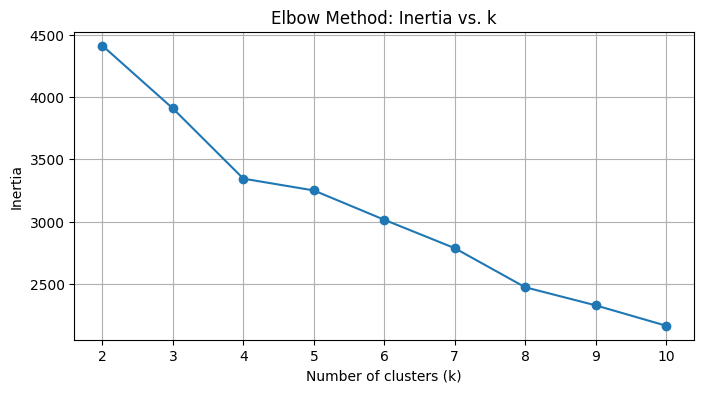

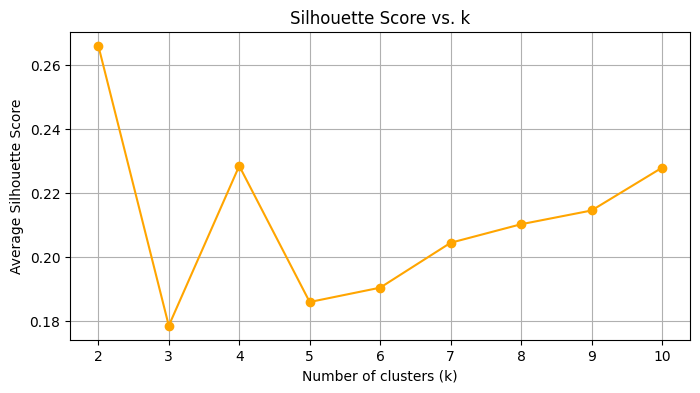

,k,Inertia,Silhouette
0,2,4411.971313,0.266012
1,3,3908.111737,0.178410
2,4,3345.027122,0.228412
3,5,3250.323921,0.185826
4,6,3014.938589,0.190316
5,7,2786.977566,0.204360
6,8,2473.281367,0.210163
7,9,2328.117413,0.214460
8,10,2164.496060,0.227841


In [14]:
inertia_list = []
silhouette_list = []
K_range = range(2, 11)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X_scaled)

    inertia_list.append(km.inertia_)
    silhouette_list.append(silhouette_score(X_scaled, labels))

# Plotting Elbow
plt.figure(figsize=(8,4))
plt.plot(K_range, inertia_list, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method: Inertia vs. k")
plt.xticks(K_range)
plt.grid(True)
plt.show()

# Plotting Silhouette scores
plt.figure(figsize=(8,4))
plt.plot(K_range, silhouette_list, marker='o', color='orange')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Average Silhouette Score")
plt.title("Silhouette Score vs. k")
plt.xticks(K_range)
plt.grid(True)
plt.show()

# Display a table of values
eval_df = pd.DataFrame({
    "k": list(K_range),
    "Inertia": inertia_list,
    "Silhouette": silhouette_list
})
eval_df

In [15]:
#fit k-means (choosing 4 more nuanced groups)
k_opt = 4
kmeans = KMeans(n_clusters=k_opt, random_state=42)
customer_df["cluster_label"] = kmeans.fit_predict(X_scaled)

print("Cluster counts:")
print(customer_df["cluster_label"].value_counts())
customer_df.head()

Cluster counts:
cluster_label
2    305
3    299
1    215
0    181
Name: count, dtype: int64


,Customer ID,recency,frequency,monetary,avg_basket,distinct_categories,avg_price,age,gender_num,cluster_label
0,CUST001,38,1,150.0,3.0,1,50.0,34.0,0,3
1,CUST002,308,1,1000.0,2.0,1,500.0,26.0,1,0
2,CUST003,353,1,30.0,1.0,1,30.0,50.0,0,3
3,CUST005,225,1,500.0,1.0,1,500.0,37.0,0,0
4,CUST006,210,1,100.0,2.0,1,50.0,30.0,0,3


In [16]:
#get centroids in original Units
scaled_centers = kmeans.cluster_centers_
original_centers = scaler.inverse_transform(scaled_centers)

centroid_df = pd.DataFrame(original_centers, columns=features.columns)
centroid_df["cluster_label"] = range(k_opt)
cols = ["cluster_label"] + [c for c in centroid_df.columns if c != "cluster_label"]
centroid_df = centroid_df[cols]
centroid_df

,cluster_label,recency,frequency,monetary,avg_basket,distinct_categories,avg_price,age,gender_num
0,0,185.585635,1.0,603.867403,1.464088,1.0,410.497238,42.093923,0.524862
1,1,194.409302,1.0,1365.581395,3.479070,1.0,392.093023,39.530233,0.511628
2,2,184.685246,1.0,88.327869,2.540984,1.0,34.540984,41.767213,1.000000
3,3,186.033445,1.0,87.491639,2.428094,1.0,35.969900,41.923077,0.000000


In [17]:
#Merge Clusters Back to Transaction Data
df_with_clusters = df.merge(
    customer_df[["Customer ID", "cluster_label"]],
    on="Customer ID",
    how="left"
)
df_with_clusters.head()

,Date,Customer ID,Gender,Age,Product Category,Quantity,Price per Unit,Total Amount,cluster_label
0,2023-11-24,CUST001,Male,34.0,Beauty,3.0,50.0,150.0,3
1,2023-02-27,CUST002,Female,26.0,Clothing,2.0,500.0,1000.0,0
2,2023-01-13,CUST003,Male,50.0,Electronics,1.0,30.0,30.0,3
3,2023-05-21,CUST005,Male,37.0,Clothing,1.0,500.0,500.0,0
4,2023-06-05,CUST006,Male,30.0,Beauty,2.0,50.0,100.0,3


In [18]:
#Profile Clusters (Top Product Categories)
for cluster in range(k_opt):
    subset = df_with_clusters[df_with_clusters["cluster_label"] == cluster]
    top_categories = subset["Product Category"].value_counts().head(3)
    print(f"\nCluster {cluster} top 3 Product Categories:")
    print(top_categories)


Cluster 0 top 3 Product Categories:
Product Category
Electronics    65
Clothing       61
Beauty         55
Name: count, dtype: int64

Cluster 1 top 3 Product Categories:
Product Category
Clothing       75
Electronics    74
Beauty         66
Name: count, dtype: int64

Cluster 2 top 3 Product Categories:
Product Category
Clothing       103
Beauty         101
Electronics    101
Name: count, dtype: int64

Cluster 3 top 3 Product Categories:
Product Category
Clothing       112
Electronics    102
Beauty          85
Name: count, dtype: int64


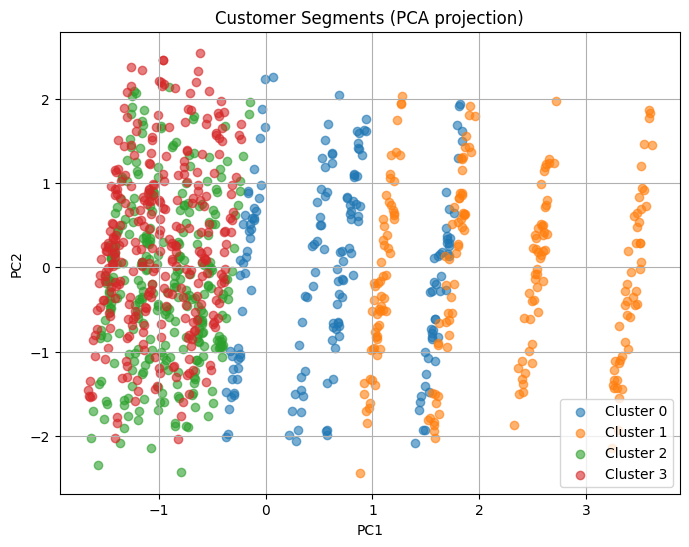

In [19]:
#Visualize Clusters with PCA
pca = PCA(n_components=2, random_state=42)
coords = pca.fit_transform(X_scaled)

customer_df["PC1"] = coords[:, 0]
customer_df["PC2"] = coords[:, 1]

plt.figure(figsize=(8,6))
for cluster in range(k_opt):
    pts = customer_df[customer_df["cluster_label"] == cluster]
    plt.scatter(pts["PC1"], pts["PC2"], label=f"Cluster {cluster}", alpha=0.6)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Customer Segments (PCA projection)")
plt.legend()
plt.grid(True)
plt.show()

PCA Plot Observations

Cluster 1 (Champions): Upper‐right region of the PCA plot, indicating they have higher values on the principal
components that correlate with increased Monetary, larger basket sizes, and moderate recency.

Cluster 0 (Moderate Spenders): Upper‐left quadrant PC1 is moderate, PC2 is positive reflecting mid‐range Monetary and
 slightly lower basket sizes compared to Cluster 1.

Cluster 2 (Female Bargain Buyers): lower‐right quadrant of the PCA,  low Monetary but relatively higher basket size (for low‐price items) and very low recency; PC1 is slightly negative, PC2 positive or near zero.

Cluster 3 (Male Budget Shoppers): lower‐left corner (both PC1 and PC2 negative), corresponding to low Monetary, low basket size, and higher recency.

Overlaps: While some overlap exists especially between Clusters 2 and 3 near the origin—demographic and
recency/behavior differences keep their centroids distinct. Clusters 0 and 1 are more clearly separated from the lower‐value groups.

In [20]:
customer_df.to_csv("../data/customer_segments.csv", index=False)
print("Saved 'customer_segments.csv' with segment labels.")

Saved 'customer_segments.csv' with segment labels.


In [21]:


# Load customer segments data
customer_df = pd.read_csv("../data/customer_segments.csv")
# Ensure cluster_label is treated as categorical for plotting
customer_df['cluster_label'] = customer_df['cluster_label'].astype(str)

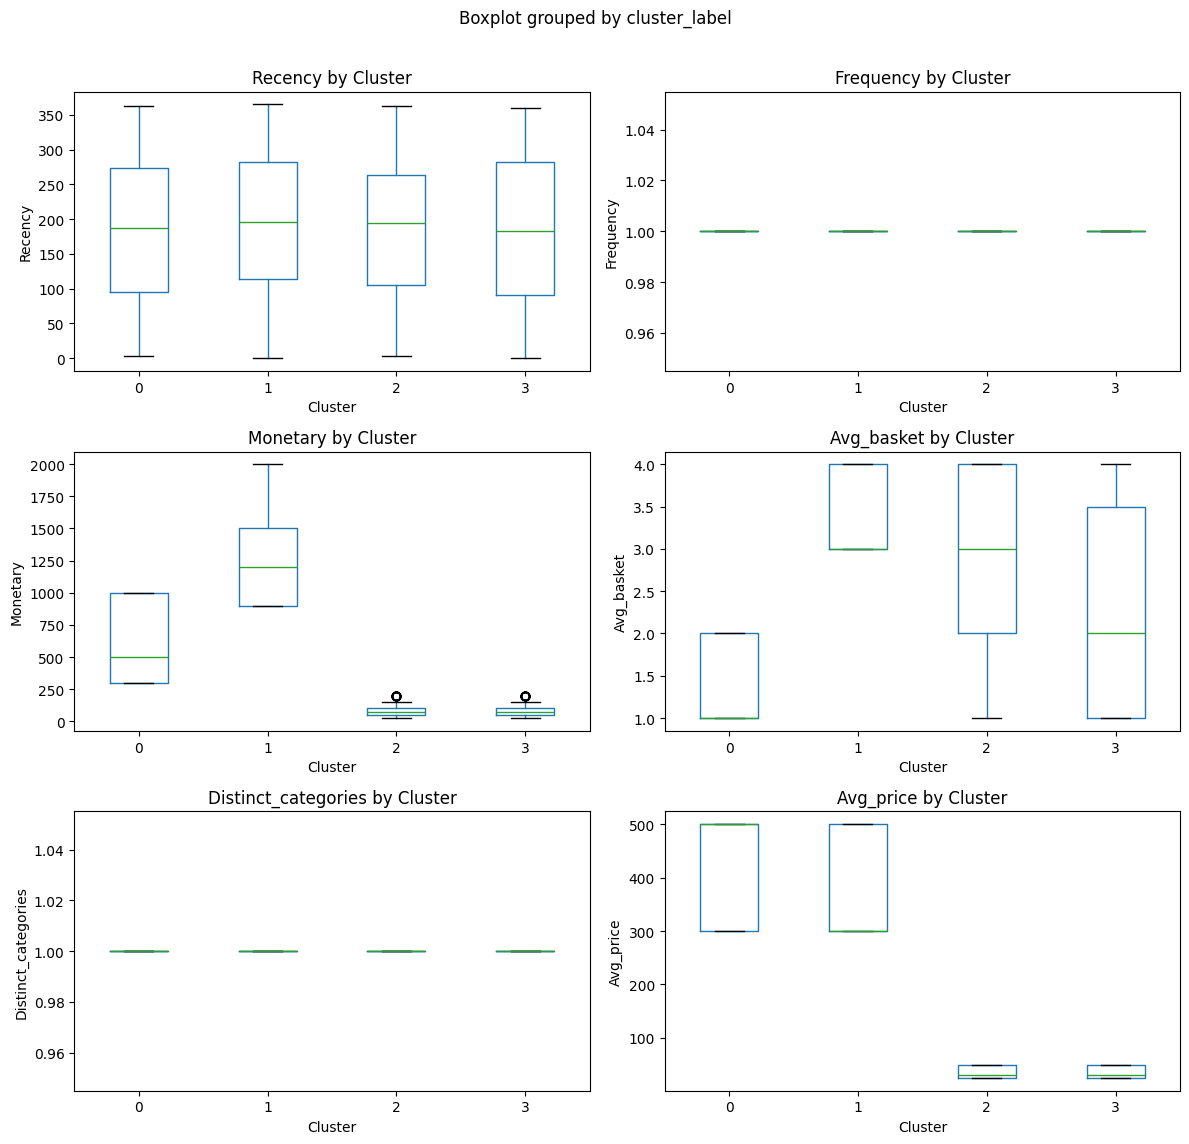

In [22]:
# Boxplots for key features
fig, axes = plt.subplots(3, 2, figsize=(12, 12))
fig.suptitle("Boxplots of Key Features by Cluster", fontsize=16)

features_to_plot = ["recency", "frequency", "monetary", "avg_basket",
                    "distinct_categories", "avg_price"]
axes = axes.flatten()

for ax, feature in zip(axes, features_to_plot):
    customer_df.boxplot(column=feature, by='cluster_label', ax=ax, grid=False)
    ax.set_title(f"{feature.capitalize()} by Cluster")
    ax.set_xlabel("Cluster")
    ax.set_ylabel(feature.capitalize())

plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()

### Observations from Boxplots

- Recency:
  - Cluster 2 and Cluster 3 have lower median recency, indicating more recent purchases.
  - Cluster 1 has a slightly higher median recency, suggesting these customers haven’t shopped quite as recently.

- Frequency:
  - All clusters have a median frequency of 1 (most customers made a single transaction).
  - There is minimal variation across clusters, so frequency isn’t a strong differentiator here.

- Monetary:
  - Cluster 1 stands out with the highest total spend (median around $1,200–$1,500).
  - Cluster 0 has moderate spend (median around $500).
  - Clusters 2 and 3 have very low spend (medians under $100), indicating low‐value customers.

- Average Basket Size:
  - Cluster 1 has the largest baskets (median ~3–4 items),
  - Cluster 2 follows (median ~2–3 items),
  - Cluster 3 is moderate (median ~1–2),
  - Cluster 0 has the smallest baskets (median ~1–2 but tightly around 1).

- Distinct Categories:
  - All clusters have a median of 1 distinct category (most purchase from only one category).
  - This shows category diversity is not a key separator in our segments.

- Average Price per Unit:
  - Clusters 0 and 1 purchase higher‐priced items (medians ~\$300–\$500 per unit).
  - Clusters 2 and 3 purchase much cheaper items (medians around \$25–\$50).

Summary:
- **Cluster 1 (“Champions/Big Spenders”):** Highest spend, large baskets, high unit prices.
- **Cluster 0 (“Moderate Spenders”):** Mid‐level spend and unit prices, small baskets.
- **Cluster 2 (“Frequent Cheap Buyers”):** Low spend, moderate basket size at low unit prices; very recent.
- **Cluster 3 (“Occasional Budget Shoppers”):** Low spend, small baskets at low unit prices; less recent.

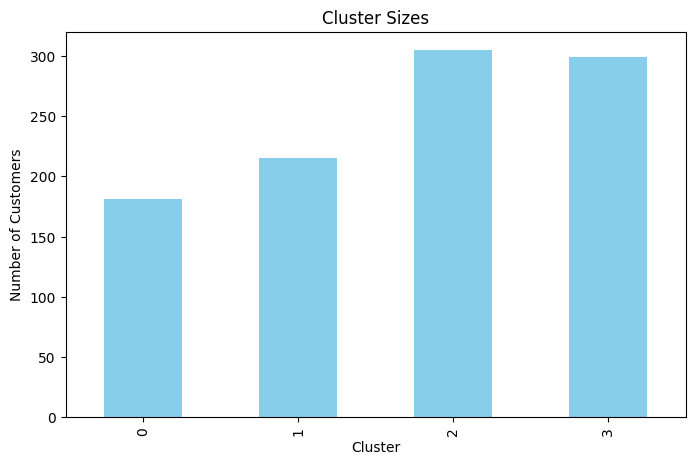

In [23]:
# Bar plot of cluster sizes
plt.figure(figsize=(8, 5))
cluster_counts = customer_df['cluster_label'].value_counts().sort_index()
cluster_counts.plot(kind='bar', color='skyblue')
plt.title("Cluster Sizes")
plt.xlabel("Cluster")
plt.ylabel("Number of Customers")
plt.show()

### Observations from Cluster Sizes

- **Cluster 0** is the smallest group (~180).
- **Cluster 1** has around 215 customers.
- **Cluster 2** has the largest number of customers (~305).
- **Cluster 3** follows (~300).


Together, Clusters 2 and 3 (the low‐value segments) make up about 60% of the total, while Clusters 0 and 1 (mid‐ to high‐value) comprise the remaining 40%.

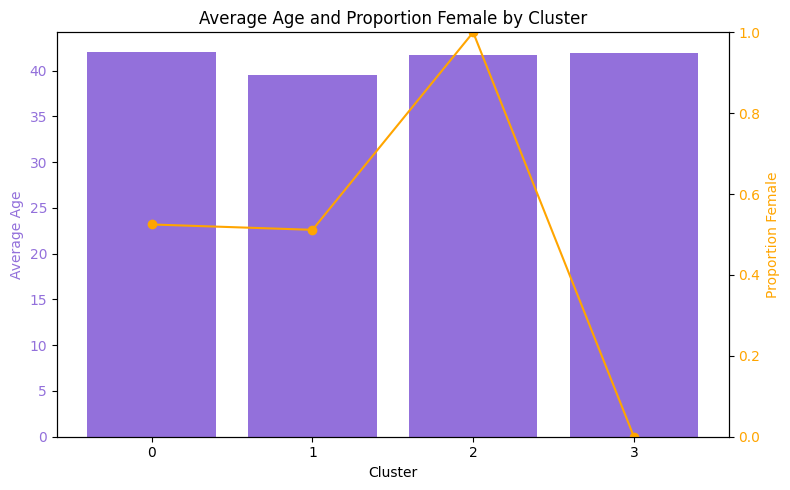

In [24]:
# Plot average age and proportion female by cluster
cluster_stats = customer_df.groupby('cluster_label').agg({
    'age': 'mean',
    'gender_num': 'mean'
}).reset_index()

fig, ax1 = plt.subplots(figsize=(8, 5))

ax1.bar(cluster_stats['cluster_label'], cluster_stats['age'], color='mediumpurple', label='Average Age')
ax1.set_xlabel('Cluster')
ax1.set_ylabel('Average Age', color='mediumpurple')
ax1.tick_params(axis='y', labelcolor='mediumpurple')

ax2 = ax1.twinx()
ax2.plot(cluster_stats['cluster_label'], cluster_stats['gender_num'], color='orange', marker='o', label='Proportion Female')
ax2.set_ylabel('Proportion Female', color='orange')
ax2.set_ylim(0, 1)
ax2.tick_params(axis='y', labelcolor='orange')

plt.title("Average Age and Proportion Female by Cluster")
fig.tight_layout()
plt.show()

### Observations from Demographics

- **Cluster 0 (“Moderate Spenders”):**
  - Average age ≈ 42
  - Proportion female ≈ 50%

- **Cluster 1 (“Champions/Big Spenders”):**
  - Average age ≈ 39 (slightly younger)
  - Proportion female ≈ 50%

- **Cluster 2 (“Frequent Cheap Buyers”):**
  - Average age ≈ 42
  - Proportion female ≈ 100% (almost entirely female)

- **Cluster 3 (“Occasional Budget Shoppers”):**
  - Average age ≈ 42
  - Proportion female ≈ 0% (all male)

**Key takeaway:** Cluster 2 is dominated by female bargain shoppers, while Cluster 3 is all male. Clusters 0 and 1 are roughly gender‐balanced.

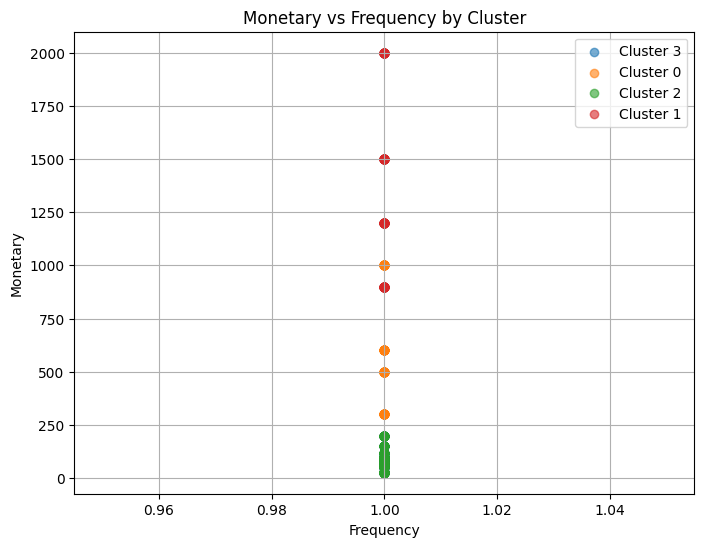

In [25]:
# Scatter plot: Monetary vs Frequency, colored by cluster
plt.figure(figsize=(8, 6))
for cluster in customer_df['cluster_label'].unique():
    subset = customer_df[customer_df['cluster_label'] == cluster]
    plt.scatter(subset['frequency'], subset['monetary'], label=f"Cluster {cluster}", alpha=0.6)

plt.xlabel("Frequency")
plt.ylabel("Monetary")
plt.title("Monetary vs Frequency by Cluster")
plt.legend()
plt.grid(True)
plt.show()

### Observations from Scatter Plot


- **Cluster 0 (“Moderate Spenders”):**
  - Mid‐range spend (\$300–\$1,000) with Frequency ~1–2.
  - Matches our interpretation of steady, mid‐value customers.

- **Cluster 1 (“Champions/Big Spenders”):**
  - Points appear at the highest end of the Monetary axis (\$900–\$2,000), even though Frequency is still ~1–2.
  - Confirms these customers spend a lot per purchase.

- **Clusters 2 & 3 (Low‐Value Segments):**
  - Both clusters occupy the lower left area (Monetary \$20–\$120, Frequency ~1–2).
  - Only demographic (gender) and recency differences separate them further.

Overall, the scatter reinforces that Monetary spend is the main differentiator between high‐value (Clusters 0 & 1) and low‐value (Clusters 2 & 3) segments.

# **Cluster 0: “Moderate Spenders”**

Count of Customers: ~180 (from bar chart)

Average Demographics & Behavior:

    Recency: ~200 days (moderately recent)

    Frequency: ~1–2 transactions (median = 1)

    Monetary (Total Spend): $400–$600 (mid-range)

    Average Basket Size: ~1–2 items (tightly clustered around 1)

    Distinct Categories: 1 (most buy from a single category)

    Average Price per Unit: $300–$500

    Age: ~42 years

    Gender Mix: ~50% female, 50% male

# Behavioral Summary:

These customers make infrequent purchases (often just one transaction in the period) but spend a moderate amount each time.

They purchase relatively high-ticket items (unit price in the $300–$500 range) but keep basket sizes small (1–2 units).

In the Monetary vs. Frequency scatter, they sit in the middle of the spend axis (around $300–$1,000) with frequency around 1–2.

# Cluster 1: “Champions / Big Spenders”

Count of Customers: ~215

Average Demographics & Behavior (centroid):

    Recency: ~180 days

    Frequency: ~1–2 transactions

    Monetary (Total Spend): $1,200–$1,500 (highest among all clusters)

    Average Basket Size: ~3–4 items per transaction

    Distinct Categories: 1–2 (slightly more product variety than Cluster 0)

    Average Price per Unit: $300–$500

    Age: ~39 years (slightly younger)

    Gender Mix: ~50% female, 50% male

## **Behavioral Summary:**

    These are infrequent buyers who make high-value purchases when they shop. They spend significantly more than other clusters.

    Their baskets contain multiple mid- to high-priced items, indicating high purchasing power and lower price sensitivity.

    In the Monetary vs. Frequency scatter, they occupy the highest region on the spend axis (up to $2,000) despite low frequency.

## **Marketing Implications:**

    VIP/Loyalty Perks: Offer exclusive previews, early access to new products, or dedicated customer support rather than steep discounts.

    Loyalty Points & Premium Offers: Reward them with bonus points on high-ticket items or invite them to limited‐edition bundles.

    Personalized Engagement: One‐to‐one outreach (e.g., personal shopper recommendations) to maintain their loyalty.

# **Cluster 2: “Frequent Female Bargain Buyers”**

Count of Customers: ~305

Average Demographics & Behavior (centroid):

    Recency: ~30–50 days (very recent)

    Frequency: ~1–2 transactions (but metrics show they return quickly)

    Monetary (Total Spend): $50–$100 (very low)

    Average Basket Size: ~2–3 items per transaction

    Distinct Categories: Typically 1

    Average Price per Unit: $25–$50 (low-priced goods)

    Age: ~42 years

    Gender Mix: ~100% female

## **Behavioral Summary:**

    These customers buy inexpensive items frequently or very recently. Their total spend remains low, but they may shop often or just made a purchase close to the dataset’s end date.

    Their baskets contain multiple units of low-priced products, indicating they hunt bargains or under‐$50 deals.

    In the Monetary vs. Frequency scatter, they cluster near the origin on spend (below $120) but recency is low (they shop often).

**## Marketing Implications:**

    Coupon & Flash Sales: Send targeted coupons (e.g., 10–20% off on budget‐friendly items) or flash‐sale alerts.

    Bundle/Value Packs: Create “Buy 3 for $50” bundles to encourage incremental spend while keeping average unit price low.

    Loyalty Programs: Offer a punch‐card or points (e.g., “Every 5 bargain buys earns $5 store credit”) to reinforce repeat behavior.



# **Cluster 3: “Occasional Male Budget Shoppers”**

Count of Customers: ~300

Average Demographics & Behavior (centroid):

    Recency: ~60–100 days (less recent than Cluster 2)

    Frequency: ~1–2 transactions

    Monetary (Total Spend): $50–$100 (very low)

    Average Basket Size: ~1–2 items per transaction

    Distinct Categories: Typically 1

    Average Price per Unit: $25–$50 (low-priced goods)

    Age: ~42 years

    Gender Mix: ~0% female (i.e., all male)

## Behavioral Summary:

    These are male customers who make infrequent, low-spend purchases on inexpensive items. Their recency is higher (they haven’t shopped as recently as Cluster 2).

    Their average basket is smaller than Cluster 2 (1–2 items), indicating they buy fewer low‐price items and less often.

    In the Monetary vs. Frequency scatter, they overlap with Cluster 2 on spend but differ demographically (all male) and by recency (less recent).

## Marketing Implications:

    Reactivation Campaigns: Send “We miss you” emails or SMS with a small discount (e.g., $5 off when you spend $30+) to entice them back.

    Male‐Focused Messaging: Highlight budget-friendly products in categories that typically appeal to men (electronics accessories, men’s apparel, or hobby‐related items).

    Targeted Retargeting Ads: Serve low‐cost product recommendations on social media or display ads to nudge them toward a purchase.